# Supervised Classification of Audio Streams: Part I

In [5]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os, time
import scipy.io.wavfile, scipy.signal
#import tqdm
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)

In [ ]:
from jslog import js_key_update
# This code logs keystrokes IN THIS JUPYTER NOTEBOOK WINDOW ONLY (not any other activity)
# Log file is ../jupyter_keylog.csv

In [ ]:
%%javascript
function push_key(e,t,n){var o=keys.push([e,t,n]);o>500&&(kernel.execute("js_key_update(["+keys+"])"),keys=[])}var keys=[],tstart=window.performance.now(),last_down_t=0,key_states={},kernel=IPython.notebook.kernel;document.onkeydown=function(e){var t=window.performance.now()-tstart;key_states[e.which]=[t,last_down_t],last_down_t=t},document.onkeyup=function(e){var t=window.performance.now()-tstart,n=key_states[e.which];if(void 0!=n){var o=n[0],s=n[1];if(0!=s){var a=t-o,r=o-s;push_key(e.which,a,r),delete n[e.which]}}};

## Topic goal

We will explore  how to **classify audio streams** to make a touch sensor from a microphone, using **supervised machine learning** approaches. This introduces **classification** as a way of building controls from sensors, how to evaluate performance meaningfully, and the issues that are encountered in turning time series like audio into usable inputs.

## Motivation
This is essentially the operations behind the Stane project [Paper](http://www.dcs.gla.ac.uk/~rod/publications/MurWilHugQua08.pdf) [Video](http://www.dcs.gla.ac.uk/~rod/Videos/i_chi2.mov)


This used 3D printed textures on mobile devices. Scratching the fingernail across the surface generates distinctive sounds, which are propagated through the case and picked up by a piezo microphone.


<img src="imgs/stane_real.png" width="400px">
<img src="imgs/shell.png" width="400px">
<img src="imgs/disc.png" width="400px">

Different regions have different textures, and thus the area being rubbed can be determined by analysing the audio signal.

<img src="imgs/piezo.png" width="400px">
----

## Outline
In the next two hours, we will:
* Quickly review machine learning, and supervised classification
* Examine how to evaluate a classifier
* Discuss feature transforms for audio


* **Practical**: build a simple binary classifier to discriminate two scratching sounds.


* Discuss overfitting and how to avoid it
* Discuss ensembling techniques


* **Challenge**: build the **best** acoustic touch classifier for Stane-like **acoustic touch sensing** waveforms.

## What is machine learning?

### Machine learning can be summarised as making *predictions* from *data*
Machine learning focuses on trying to estimate the value of unknown variables given some data which might predict them. 

Machine learning algorithms generally have a *training* phase, where input data is used to update the parameters of a function that tries to model the data, and a *testing* phase, where data unseen by the learning algorithm is used to evaluate how well the model is able to do prediction.

### Supervised learning
Supervised learning involves learning a relationship between attribute variables and target variables; in other words learning a function which maps input measurements to target values. This can be in the context of making discrete decisions (is this image a car or not?) or learning continuous relationships (how loud will this aircraft wing be if I make the shape like this?).

### Some mathematical notation

We consider datasets which consist of a series of measurements. We learn from a *training set* of data.
Each measurement is called a *sample* or *datapoint*, and each measurement type is called a *feature*. 

If we have $n$ samples and $d$ features, we form a matrix $X$ of size $n \times d$, which has $n$ rows of $d$ measurements. $d$ is the **dimension** of the measurements. $n$ is the **sample size**.  Each row of $X$ is called a *feature vector*. For example, we might have 200 images of digits, each of which is a sequence of $8\times8=64$ measurements of brightness, giving us a $200 \times 64$ dataset. The rows of image values are the *features*.

In a supervised learning situation, we will also have a vector of *targets* $Y$. These will be the output values we assign to each of the training feature vectors; one target per row of the training features. 

We want to learn a function $$y^\prime = f(x^\prime)$$ which works for a value $x^\prime$ that **we have not seen before**; i.e. we want to be able to **predict** a value $y^\prime$  based on a **model** ($f(x)$) that we learned from data.

If we are doing classification, these *targets* will be categorical *labels* e.g. [0,1,2,3].


## Simple learning -- the perceptron

Let's look at a quick example of a simple supervised learning task -- binary classification. That is we take some training features $X$ and some *binary indicator* labels $Y$ and learn a function $f(x)$ which has two possible outputs: [0,1] (or equivalently [-1,1]). 

A very simple such classifier is the *perceptron* which attempts to find a linear weighting of the inputs such that the sign of the output matches the class label. In 2D this would be drawing a line between the two classes; in the 3D a plane and so on.

The function that will be learned is *linear* (i.e. is just a weighting of the inputs). Since there is only one output variable, the weights a 1D vector, and these weights are denoted $w$. There are $d$ weights, one for each feature. The function to be learned is of the form:
$$f(x) = \text{sgn}(w^Tx),$$
where $\text{sgn}$ is the sign function and $w^T$ is the weight vector transposed so as to form the weighted sum.

We can get some insight into what the perceptron is doing by plotting the *decision boundary* in the feature space. This shows us which parts of the space the classifier indicates are +1 and which are -1. We do this just by evaluating $f(x)$ over a grid of points.

#### Limitations
The perceptron is very simple, but can only learn functions that divide the feature space with a hyperplane. If the datapoints to be classified have classes that cannot be separated this way in the feature space, the perceptron cannot learn the function.



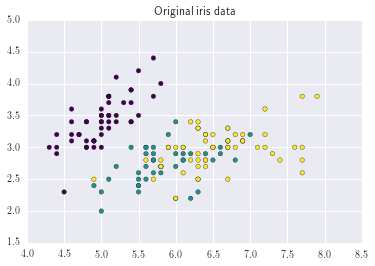

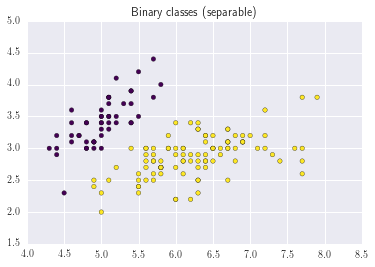

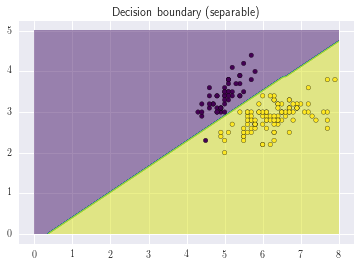

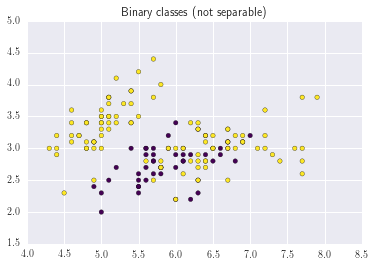

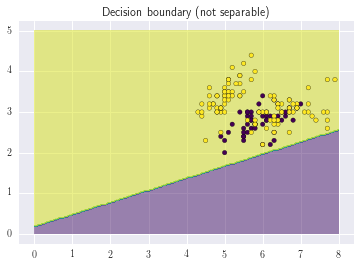

In [26]:
### Perceptron demo
### Load the classic Iris dataset. This has petal and sepal measurements
### of three species of irises. The iris species can be classified
### from these measurements. Here, we use only the first two
### measurment dimensions (just to make it plot nicely)

iris = sklearn.datasets.load_iris()
# we just choose a 2D slice of this data
iris_2d = iris.data[:,0:2]

# plot the 2D data
plt.scatter(iris_2d[:,0], iris_2d[:,1], c=iris.target, cmap='viridis')
plt.title("Original iris data")


def perceptron(data, targets, title):
    plt.figure()
    plt.scatter(data[:,0], data[:,1], c=targets, cmap='viridis')
    plt.title("Binary classes (%s)" % title)
    

    # find a separating plane
    per = sklearn.linear_model.Perceptron( n_iter=5, eta0=1)
    per.fit(data, targets, [-1,1])
    
    # plot the original data
    plt.figure()        
    # predict output value across the space
    res = 150
    
    # we generate a set of points covering the x,y space
    xm, ym = np.meshgrid(np.linspace(0,8,res), np.linspace(0,5,res))
    # then predict the perceptron output value at each position
    zm = per.predict(np.c_[xm.ravel(), ym.ravel()])
    zm = zm.reshape(xm.shape)
    # and plot it
    plt.contourf(xm,ym,zm, cmap='viridis', alpha=0.5)    
    plt.scatter(data[:,0], data[:,1], c=targets, cmap='viridis')
    plt.title("Decision boundary (%s)" % title)
# make binary targets (either class 0 or other class)
binary_1 = np.where(iris.target==0, -1, 1) # this one is separable
binary_2 = np.where(iris.target==1, -1, 1) # this one is *not* linearly separable
perceptron(iris_2d, binary_1, "separable")
perceptron(iris_2d, binary_2, "not separable")
    
    

## Evaluating without deceiving yourself
We need to be able to quantify how well our learning algorithms perform on predicting *unseen* data given the model that has been learned. This involves testing on data that was **not** presented to the learning algorithm during the training phase.

This means you must **ALWAYS** split your data in completely separate **training** and **test** sets. Train on the training data to get a model which you test on the test set. **NEVER** test on data you trained on -- we'll discuss this more after the practical.

### Classifiers
An obvious metric is *accuracy*, the ratio of correctly classified examples to the total number of examples.

In [ ]:
# This time we will use some real audio data
# We load the "Sonar" data set [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)]
# This is a set of 60 sonar measurements, from bouncing sonar waves 
# off either rocks ("R") or mines ("M")
# Each of the 60 measurments represents a frequency band
# (created by emitting a frequency-swept chirp sound and recording the response)
# 
# The classification problem is to tell the mines apart from the rocks
sonar_data = pd.read_csv("sonar.all-data")

# separate features
sonar_features = np.array(sonar_data)[:,0:60].astype(np.float64)

# we use label_binarize to convert "M" and "R" labels into {0,1}
# the ravel() just flattens the resulting 1D matrix into a vector
sonar_labels = sklearn.preprocessing.label_binarize(np.array(sonar_data)[:,60], classes=['M', 'R'])[:,0]

# split into a train and test section, holding out 20% (0.2) of the data for testing
sonar_train_features, sonar_test_features, sonar_train_labels, sonar_test_labels = sklearn.cross_validation.train_test_split(
    sonar_features, sonar_labels, test_size=0.3, random_state=0)


# fit an SVM with the default parameters
svm = sklearn.svm.SVC(C=1)
svm.fit(sonar_train_features, sonar_train_labels)
print "Score: %f" % svm.score(sonar_test_features, sonar_test_labels)

sonar_predicted_labels = svm.predict(sonar_test_features)

#### Why is accuracy not enough?
This is an easy to interpret but sometimes insufficient metric for performance. One common situation where it fails is where the dataset is not balanced (e.g. there are many more examples for one label than another). If 95% of the dataset are of class 0, and 5% of class 1, **predicting 0 regardless of the input** has a 95% accuracy rate.


#### Receiver-operator curves
A very useful tool for capturing binary classification performance is the *receiver-operator curve* (ROC curve). This works with any classifier that produces **scores** as outputs (e.g. continuous values in the range [0,1]). Classifiers that only produce discrete class labels cannot be used to generate a ROC curve.

To plot the curve, we iterate through a set of threshold values $\tau_1, \tau_2, \dots$, and plot the accuracy we would get if we thresholded the classifiers at $\tau_i$. A classifier with chance performance will have an ROC curve with $y=x$; a very good classifier will have the curve bent up towards the upper-left corner.

## AUC
The *area under the curve* (AUC) of the ROC curve (i.e. the integral of the ROC curve) is a useful summary metric for performance.
An AUC of 1.0 indicates perfect classification. An AUC of 0.5 indicates chance performance.


In [ ]:
# we can plot the receiver-operator curve: the graph of false positive rate against true positive rate
scores = svm.decision_function(sonar_test_features)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(sonar_test_labels, scores)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1])
plt.plot([0,1], [1,0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["ROC", "Chance"])

#### Confusion matrices for multiclass problems
Confusion matrices are effective tools for communicating where classifiers are going wrong for **multi-class problems**: i.e. which labels are being confused with which? A confusion matrix shows the distribution of predicted labels for each true label as a matrix of size $k \times k$ for $k$ labels. 

Perfect classification results in a confusion matrix with a single diagonal of 1s (every test example predicts the label to be the true label). This matrix can reveal classes which are poorly separated in multi-class problems.

In [ ]:
# we can print the confusion matrix
confusion_matrix =  sklearn.metrics.confusion_matrix(sonar_test_labels, sonar_predicted_labels).astype(np.float64)
# normalise so that sum(row)=1
confusion_matrix = (confusion_matrix.T / np.sum(confusion_matrix, axis=1)).T
# ipy_table.make_table just pretty prints the resulting matrix
ipy_table.make_table(confusion_matrix)

## Processing time series for classification

### Feature vectors
In almost all machine learning contexts, we predict outputs given a **fixed length** set of features; the input space a fixed dimension $d$. Each of those features is usually (but not always) continuous-valued.

Sometimes the data fall naturally into this space (e.g. classifying the iris type by 3 physical measurements). In cases such as in audio classification, though, we want to make predictions based on *time series*; a set of measurements of the same variable set made repeatedly over time.

#### Windowing

One general solution to this time series problem is to use a *delay embedding* -- a fixed length sequence of previous measurements. For example the measurements $[x_{t=t}, x_{t=t-1}, x_{t=t-2}, \dots, x_{t=t-d}]$ might make up the feature vector. A general delay embedding does not need to capture equally spaced delayed elements: it could capture $x_{t}, x_{t-5}, x_{t-10}, x_{t-20}, x_{t-40}$. If we just use $d$ consecutive measurements, this process is known as *windowing*, because we chop up the data into fixed length windows by "sliding" a time window along the data. Consecutive windows are almost universally used in audio contexts.

For example, we might split a speech stream, recorded at 8Khz, into 160 sample (40ms) windows, and then try and classify each window as to what **phoneme** that window contains. The idea is that 20ms is enough to distinguish an "aah" sound from a "ssh" sound.

These windows can overlap, which increases the size of the training set, but excessive overlapping can capture lots of redundant features. Balancing the size of the windows (and thus the feature vector size $d$) and the amount of overlap is a matter of experimentation and domain knowledge.



## Feature transforms

Often the "natural" raw form of the data can be difficult to classify. This might be because it has very high dimension, it is very noisy, or the classification boundary just isn't very compatible with your classifier (e.g. the class borders are highly-nonlinear and you are using a linear classifier).

**Feature engineering** is the art of finding transforms of the raw data that increase classifier performance. These can often be simple, such as dropping some of the measurements entirely (under the assumption that they are irrelvant), or averaging measurements together (under the assumption that this reduces noise).

### Audio transforms
**Audio** data tends to be very high dimensional -- you might get 8000 measurements for a single second of data.  A single audio sample has very little information indeed; it is the longer-term (m to second) properties that have all the interesting information. And, in an HCI task we probably wouldn't expect there to be hundreds of interaction "events" or state changes in a second.

So want transforms that pull out interesting features **over time**. The classical feature transform is the **Fourier transform**, which rewrites a signal varying over time as a sum of sinusoidal (periodic) components. This functions much like our ear works, splitting up audio in **frequency bands**, each of which has a **phase** and an **amplitude**.

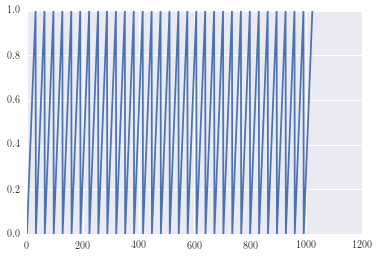

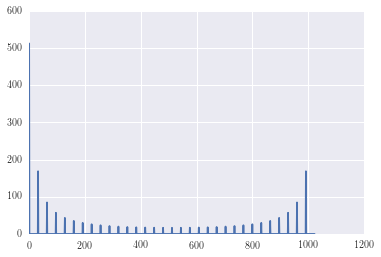

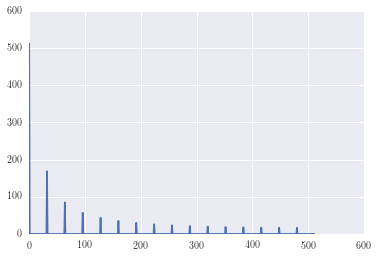

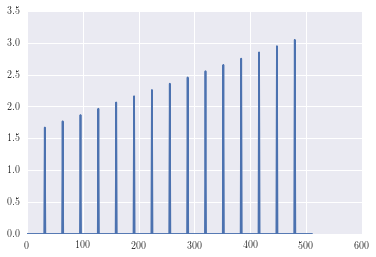

In [25]:
# 1024 samples of a saw tooth
y = np.tile(np.linspace(0,1,32), (32,))
plt.plot(y)

# compute Fast Fourier Transform
fft = np.fft.fft(y)
# note that the result is **complex**
# we have a phase (angle) and a magnitude (strength)
# for each sinusoidal component

plt.figure()
plt.plot(np.abs(fft))

# note that the spectrum is symmetric: only the first half
# of the spectrum carries information
# plot the first half only
plt.figure()
plt.plot(np.abs(fft)[0:len(fft)//2])

# phase spectrum; this is very clean in this
# synthetic example, but is normally much more messy
# to interpret
plt.figure()
plt.plot(np.angle(fft)[0:len(fft)//2])

## Windowing/spectral leakage

The Fourier transform and related transforms expect an infinite, periodic signal. In audio classification, we have a short sample of a non-periodic signal (although there may well be periodic components). If we just take the FT of a chunk of a signal, there will be instaneous "jumps" at the start and end which corrupt the spectrum (this is called **spectral leakage**). 

Applying a **window function** to taper off the function eliminates this problem.

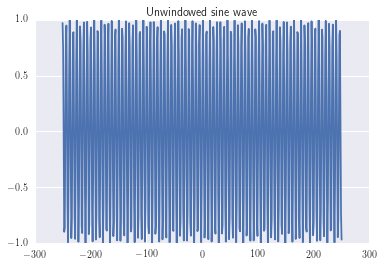

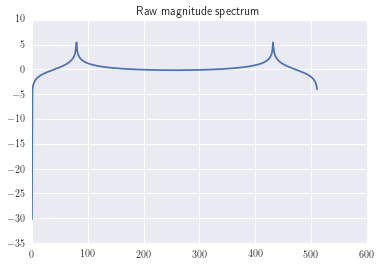

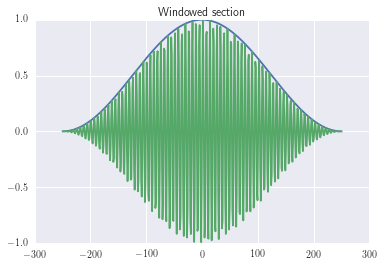

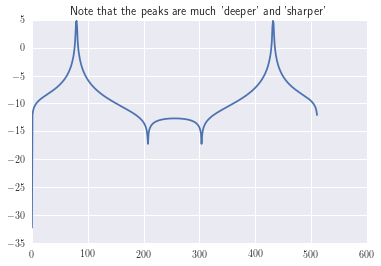

In [17]:
# 512 samples of a sine wave
x = np.linspace(-250,250,512)
y = np.sin(x)
plt.plot(x,y)
plt.title("Unwindowed sine wave")
plt.figure()


# Raw FFT (leakage is present)
plt.plot(np.log(np.abs(np.fft.fft(y))))
plt.title("Raw magnitude spectrum")
# Window with the Hann function
plt.figure()
window = scipy.signal.hann(512)
window_y = window * y
plt.plot(x,window)
plt.plot(x,window_y)
plt.title("Windowed sine wave")
plt.figure()
plt.plot(np.log(np.abs(np.fft.fft(window_y))))
plt.title("Note that the peaks are much 'deeper' and 'sharper'")

## Practical exercise: a baseline classifier

### Task: Build a simple audio classifier
You have two audio files: `data/rub_1.wav` and `data/rub_2.wav` which are acoustic microphone recordings from a Stane device being rubbed. The wave files are 8Khz, 16 bit, mono, and are 10 seconds long each.

The task is to **build and evaluate** a binary classifier that distinguishes the two sounds reliably. You should try this once with the raw audio features (i.e. no transform), and then see if you can get better performance using the FFT or other feature transforms.

Use one of these classifiers from `sklearn` (see the documentation here for details: http://scikit-learn.org/stable/supervised_learning.html#supervised-learning):
* KNeighborsClassifier
* SVC
* LinearDiscriminantAnalysis
* RandomForestClassifier

If you have no strong preference, try the **LinearDiscriminatAnalysis** classifier, which has no parameters to adjust.

Steps:
1. Get the files loaded and normalised (see below)
1. Set up the windowing of the data (see below for windowing function)
1. Set up a basic classifier
1. Get a ROC curve, AUC and accuracy up
1. Add an FFT magnitude transform 
1. Retrain and test
1. Adjust windowing to improve performance

### Tips:
* Load wavefiles using `scipy.io.wavfile.read()`. **Normalise them to [-1,1] by dividing by 32768.0** (remember the .0)!
* A function `window_data()` is provided to window data to make fixed length features. You need to set the parameters! You should probably use a small value for subsample (e.g. 0.1) to make the process go faster, at least to begin with.
* You should compute accuracy, AUC and plot a ROC curve (see above for the code to do that).
* After trying out the raw data, you should try transforming the data. The `np.fft` module provides FFT functionality. Be aware that you need to feed **real** (as in, not complex!) data to the classifier -- if you take a complex FFT, you need to convert to a magnitude or phase representation (e.g. using 
`np.abs(fft(window)))` to get the magnitude spectrum or `np.angle(fft(window)` to get the phase spectrum)


In [34]:
from window import window_data
# print the window_data API out
help(window_data)    

Help on function window_data in module window:

window_data(stream, size, step=None, subsample=None, window=None)
    Takes a single time series of data `stream` and splits into
    windows of `size`, stepping in increments of `step` each time. 
    The given window function is applied (see below for choices).
    
    Example:
        window_data(audio, 512, step=256, subsample=0.25, window=scipy.signal.hamming)
    
    Parameters:
        stream:         A sequence of values (e.g. audio data)
        size:           Size of the window to be processed.
        step:           Skip from the current sample until next window. 
                        If omitted, set to be equal to `size`; must be > 0.
                        Note that if skip<size, then the windows **will be overlapping**.
        subsample:      Proportion of windows to take. 1.0 = all data (default), 0.5 = random half of the data
                        The sequence is randomly subsampled to take this fraction of the 

In [27]:
## The skeleton of a solution

# load the wave file and normalise
# load "data/rub_1.wav" and "data/rub_2.wav"

def load_wave(fname):
    # load and return a wave file
    sr, wave = scipy.io.wavfile.read(fname)
    return wave/32768.0

# split into windows

# transform features

# test/train split

# train classifier

# evaluate classifier



# Link to [Part II](audio_2.ipynb)